EX 8 GPT LLM

In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataset
import json
from transformers import AutoTokenizer, PreTrainedTokenizerFast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from tokenizers import Tokenizer
from tokenizers.processors import TemplateProcessing

In [2]:
torch.set_float32_matmul_precision("high")

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
pip install datasets torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [5]:
from datasets import load_dataset
ds = load_dataset("imdb")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [7]:
train = pd.DataFrame(ds['train'])
test = pd.DataFrame(ds['test'])

In [8]:
unsupervised = pd.DataFrame(ds['unsupervised'])

In [10]:
X_train, X_test =  train['text'], test['text']

In [11]:
X_train, X_val =  train_test_split(
    X_train, test_size=0.1, random_state=42)

In [12]:
print(len(X_train), len(X_val), len(X_test))

22500 2500 25000


In [16]:
checkpoint = 'HuggingFaceTB/SmolLM-135M-Instruct'
pretrained_tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/3.59k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

In [17]:
pretrained_tokenizer("Attention Is All You Need")

{'input_ids': [41319, 1431, 2018, 1206, 11448], 'attention_mask': [1, 1, 1, 1, 1]}

In [19]:
pretrained_tokenizer.tokenize("Attention Is All You Needasdasd")

['Attention', 'ĠIs', 'ĠAll', 'ĠYou', 'ĠNeed', 'as', 'das', 'd']

In [30]:
pretrained_tokenizer.special_tokens_map

{'bos_token': '<|im_start|>',
 'eos_token': '<|im_end|>',
 'unk_token': '<|endoftext|>',
 'pad_token': '<|im_end|>',
 'additional_special_tokens': ['<|im_start|>', '<|im_end|>']}

In [38]:
tokenizer = Tokenizer.from_pretrained(checkpoint)

In [39]:
tokenizer.post_processor = TemplateProcessing(
        single="<|im_start|> $A <|im_end|>",
        special_tokens=[
            ("<|im_end|>", pretrained_tokenizer.eos_token_id),
            ("<|im_start|>", pretrained_tokenizer.bos_token_id),
        ],
    )
tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer,
        unk_token="<|endoftext|>",
        bos_token="<|im_start|>",
        pad_token="<|im_end|>",
        eos_token="<|im_end|>",
    )

In [40]:
tokenizer("Attention Is All You Need")

{'input_ids': [1, 41319, 1431, 2018, 1206, 11448, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [41]:
tokenizer("Attention Is All You Need", "Attention Is All You Need")

{'input_ids': [41319, 1431, 2018, 1206, 11448, 41319, 1431, 2018, 1206, 11448], 'token_type_ids': [0, 0, 0, 0, 0, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [42]:
tokenizer.tokenize("Attention Is All You Need")

['Attention', 'ĠIs', 'ĠAll', 'ĠYou', 'ĠNeed']

In [43]:
tokenizer.vocab_size

49152

In [ ]:
list(tokenizer.vocab)[:10]

['ĠJesus',
 'Ġmeditate',
 'ĠEqually',
 'ĠMama',
 'found',
 'SS',
 'Ġbinary',
 'backward',
 'Ġep',
 'Ġlists']

In [44]:
X_train   = tokenizer(X_train.to_list())
X_val     = tokenizer(X_val.to_list())
X_test    = tokenizer(X_test.to_list())

In [45]:
tokenizer("Attention Is All You Need")

{'input_ids': [1, 41319, 1431, 2018, 1206, 11448, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [46]:
tokenizer.decode([1, 41319, 1431, 2018, 1206, 11448, 2])

'<|im_start|>Attention Is All You Need<|im_end|>'

In [47]:
tokenizer.tokenize("Attention Is All You Need")

['Attention', 'ĠIs', 'ĠAll', 'ĠYou', 'ĠNeed']

In [48]:
tokenizer("Attention Is All You Need").word_ids()

[None, 0, 1, 2, 3, 4, None]

In [49]:
tokenizer("Gradients")

{'input_ids': [1, 39844, 1526, 2], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.tokenize("Gradients")

['Grad', 'ients']

In [50]:
tokenizer.pad_token_id

2

In [ ]:
def data_generator(X, max_len=512, batch_size=32, shuffle_data=True, pad_token_id=tokenizer.pad_token_id):

    input_ids = X['input_ids']
    att_mask = X['attention_mask']

    if shuffle_data:
        input_ids, att_mask = shuffle(input_ids, att_mask)

    n_batches = int(np.ceil(len(input_ids) / batch_size))

    for batch in range(n_batches):
        end = min((batch + 1) * batch_size, len(input_ids))

        input_ids_batch = input_ids[batch * batch_size:end]
        att_mask_batch = att_mask[batch * batch_size:end]

        batch_max_len = np.max([len(x) for x in input_ids_batch])
        batch_max_len = min(batch_max_len, max_len)

        for sample in range(len(input_ids_batch)):
            x = input_ids_batch[sample]
            if len(x) > batch_max_len:
                x = x[-batch_max_len:]
            pad = [pad_token_id] * (batch_max_len - len(x))
            input_ids_batch[sample] = pad + x

            x = att_mask_batch[sample]
            if len(x) > batch_max_len:
                x = x[-batch_max_len:]
            pad = [0] * (batch_max_len - len(x))
            att_mask_batch[sample] = pad + x

        input_ids_batch = torch.from_numpy(np.array(input_ids_batch)).long()
        att_mask_batch = torch.from_numpy(np.array(att_mask_batch)).long()

        yield input_ids_batch, att_mask_batch

In [ ]:
torch.roll(torch.tensor([1, 2, 3]), shifts=-1, dims=0)

tensor([2, 3, 1])

In [51]:
def train_step(model,
               data_loader,
               loss_fn,
               optimizer,
               device):

    model.train()

    train_loss = []

    for input_ids, att_mask in data_loader():
        input_ids, att_mask = input_ids.to(device), att_mask.to(device)
        optimizer.zero_grad()

        # shift targets backwards
        targets = input_ids.clone().detach()
        targets = torch.roll(targets, shifts=-1, dims=1)
        targets[:, -1] = tokenizer.pad_token_id
        # targets.shape: [n_samples, max_seq_len]

        y_pred = model(input_ids, att_mask)
        # y_pred.shape: [n_samples, max_seq_len, vocab_size]
        # but PyTorch expects [n_samples, vocab_size, max_seq_len]
        # loss = loss_fn(y_pred.transpose(2, 1), targets)
        # the fast way to do it
        # y_pred.shape: [n_samples * max_seq_len, vocab_size]
        loss = torch.nn.functional.cross_entropy(
                y_pred.reshape((-1, y_pred.size(-1))),
                targets.reshape(-1),
            )
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()

    return np.mean(train_loss)

def test_step(model,
              data_loader,
              loss_fn,
              device):
    model.eval()

    test_loss = []

    with torch.inference_mode():
        for input_ids, att_mask in data_loader():
            input_ids, att_mask = input_ids.to(device), att_mask.to(device)

            targets = input_ids.clone().detach()
            targets = torch.roll(targets, shifts=-1, dims=1)
            targets[:, -1] = tokenizer.pad_token_id
            # targets.shape: [n_samples, max_seq_len]
            y_pred = model(input_ids, att_mask)
            # y_pred.shape: [n_samples, max_seq_len, vocab_size]
            # but PyTorch expects [n_samples, vocab_size, max_seq_len]
            # loss = loss_fn(y_pred.transpose(2, 1), targets)
            # the fast way to do it
            loss = torch.nn.functional.cross_entropy(
                    y_pred.reshape((-1, y_pred.size(-1))),
                    targets.reshape(-1),
                )

            test_loss.append(loss.item())

    return np.mean(test_loss)

def train(model,
          train_data_loader,
          test_data_loader,
          optimizer,
          loss_fn,
          epochs,
          device):

    results = {
        "train_loss": [],
        "test_loss": [],
        }

    model.to(device)

    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss = train_step(model=model,
                                          data_loader=train_data_loader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        end_time = timer()
        test_loss = test_step(model=model,
          data_loader=test_data_loader,
          loss_fn=loss_fn,
          device=device)

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"time: {(end_time-start_time):.4f}"
        )

    return results

In [52]:
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()


In [55]:
torch.tril(torch.ones(5, 5))

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

In [56]:
cm = torch.tril(torch.ones(5, 5)).view(1, 1, 5, 5)
cm

tensor([[[[1., 0., 0., 0., 0.],
          [1., 1., 0., 0., 0.],
          [1., 1., 1., 0., 0.],
          [1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1.]]]])

In [57]:
cm.masked_fill(cm[:, :, :5, :5] == 0, float('-inf'))

tensor([[[[1., -inf, -inf, -inf, -inf],
          [1., 1., -inf, -inf, -inf],
          [1., 1., 1., -inf, -inf],
          [1., 1., 1., 1., -inf],
          [1., 1., 1., 1., 1.]]]])

In [58]:
torch.ones([1, 4])

tensor([[1., 1., 1., 1.]])

In [62]:
torch.ones([1, 4]).view(1, 1, 1, 4)

tensor([[[[1., 1., 1., 1.]]]])

In [59]:
tensor = torch.ones([1, 4])
tensor[:, None, None, :]

tensor([[[[1., 1., 1., 1.]]]])

In [97]:
class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, max_len):
        # D: d_model i.e. model size
        # d_v: value head size
        # d_k: key head size
        # h: n_heads
        # Assume d_v = d_k
        super().__init__()
        assert d_model % n_heads == 0
        d_k = d_model // n_heads
        self.d_k = d_k
        self.n_heads = n_heads

        self.key = nn.Linear(d_model, d_k * n_heads)
        self.query = nn.Linear(d_model, d_k * n_heads)
        self.value = nn.Linear(d_model, d_k * n_heads)

        self.fc = nn.Linear(d_k * n_heads, d_model)

        # causal mask
        cm = torch.tril(torch.ones(max_len, max_len))
        self.register_buffer(
            "causal_mask",
            cm.view(1, 1, max_len, max_len)
        )

    def forward(self, q, k, v, pad_mask=None):
        # D: d_model i.e. model size
        # N: n_samples
        # d_v: value head size
        # d_k: key head size
        # h: n_heads
        # T: seq_len i.e. time steps
        # Assume d_v = d_k
        # q.shape == k.shape == v.shape == N x T x D == N x T x (h * d_k)
        q = self.query(q) # N x T x (h * d_k)
        k = self.key(k)   # N x T x (h * d_k)
        v = self.value(v) # N x T x (h * d_v)

        N = q.shape[0]
        T = q.shape[1]

        # change the shape to:
        # (N, T, h, d_k) -> (N, h, T, d_k)
        q = q.view(N, T, self.n_heads, self.d_k).transpose(1, 2)
        k = k.view(N, T, self.n_heads, self.d_k).transpose(1, 2)
        v = v.view(N, T, self.n_heads, self.d_k).transpose(1, 2)

        # compute attention weights
        # (N, h, T, d_k) x (N, h, d_k, T) --> (N, h, T, T)
        # N, M, T, d_k @ N, M, d_k, T -> N, M, T, T
        # for i in [1..T]:
        #     for j in [1..d_k]:
        #         T, d_k @ d_k, T -> T, T

        attn_scores = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)
        if pad_mask is not None:
            attn_scores = attn_scores.masked_fill(
                pad_mask[:, None, None, :] == 0, float(-10000))

        attn_scores = attn_scores.masked_fill(
              self.causal_mask[:, :, :T, :T] == 0, float(-10000))
        attn_weights = F.softmax(attn_scores, dim=-1)

        # compute attention-weighted values
        # (N, h, T, T) x (N, h, T, d_k) --> (N, h, T, d_k)
        A = attn_weights @ v

        # reshape it back before final linear layer
        A = A.transpose(1, 2) # (N, T, h, d_k)
        # self.d_k * self.n_heads = D
        A = A.contiguous().view(N, T, self.d_k * self.n_heads) # (N, T, h * d_k)

        return self.fc(A) # shape: N x T x D
        # for i in [1..N]:
        #     for j in [1..T]:
        #         D @ D x D -> D

In [95]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, max_len, dropout_prob=0.1):
        super().__init__()

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.mha = CausalSelfAttention(d_model, n_heads, max_len)
        self.ann = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(dropout_prob),
        )
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x, pad_mask=None):
        x = self.ln1(x + self.mha(x, x, x, pad_mask))
        x = self.ln2(x + self.ann(x))
        x = self.dropout(x)
        return x

In [64]:
torch.arange(5).unsqueeze(1)

tensor([[0],
        [1],
        [2],
        [3],
        [4]])

In [ ]:
torch.arange(5)

tensor([0, 1, 2, 3, 4])

In [66]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512, dropout_prob=0.1):
        # N: n_samples
        # T: seq_len i.e. time steps
        # D: d_model i.e. model size
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_prob)

        position = torch.arange(max_len).unsqueeze(1)
        # possition.shape: 1 x T
        exp_term = torch.arange(0, d_model, 2)
        div_term = torch.exp(exp_term * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        # pe.shape: 1 x T x D
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x.shape: N x T x D
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [88]:
pe = PositionalEncoding(8)
pe.eval()
pe(torch.zeros([1, 4, 8]))

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           1.0000e+00,  0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  9.9833e-02,  9.9500e-01,  9.9998e-03,
           9.9995e-01,  1.0000e-03,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  1.9867e-01,  9.8007e-01,  1.9999e-02,
           9.9980e-01,  2.0000e-03,  1.0000e+00],
         [ 1.4112e-01, -9.8999e-01,  2.9552e-01,  9.5534e-01,  2.9995e-02,
           9.9955e-01,  3.0000e-03,  1.0000e+00]]])

In [87]:
pe = PositionalEncoding(4)
pe.train()
pe(torch.zeros([1, 4, 4]))

tensor([[[ 0.0000,  1.1111,  0.0000,  1.1111],
         [ 0.9350,  0.6003,  0.0111,  1.1111],
         [ 1.0103, -0.4624,  0.0222,  0.0000],
         [ 0.1568, -0.0000,  0.0333,  1.1106]]])

In [89]:
def example_positional():
    import altair as alt

    pe = PositionalEncoding(20, max_len=100, dropout_prob=0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )

example_positional()

alt.Chart(...)

In [91]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 max_len,
                 d_model,
                 n_heads,
                 n_layers,
                 dropout_prob):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
        transformer_blocks = [
            TransformerBlock(
                d_model,
                n_heads,
                max_len,
                dropout_prob) for _ in range(n_layers)]
        self.transformer_blocks = nn.Sequential(*transformer_blocks)
        self.ln = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x, pad_mask=None):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        for block in self.transformer_blocks:
            x = block(x, pad_mask)
        x = self.ln(x)
        x = self.fc(x)
        return x

In [92]:
tokenizer.pad_token_id

2

In [93]:
train_gen   = lambda : data_generator(X_train, max_len=256, batch_size=32)
val_gen     = lambda : data_generator(X_val, max_len=256, shuffle_data=False)
test_gen    = lambda : data_generator(X_test, max_len=256, shuffle_data=False)

In [98]:
model = Decoder(
    vocab_size=tokenizer.vocab_size,
    max_len=256,
    d_model=512,
    n_heads=8,
    n_layers=6,
    dropout_prob=0.1
)
model.to(device)

Decoder(
  (embedding): Embedding(49152, 512)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mha): CausalSelfAttention(
        (key): Linear(in_features=512, out_features=512, bias=True)
        (query): Linear(in_features=512, out_features=512, bias=True)
        (value): Linear(in_features=512, out_features=512, bias=True)
        (fc): Linear(in_features=512, out_features=512, bias=True)
      )
      (ann): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=2048, out_features=512, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (ln1): LayerNorm((5

In [99]:
sum(p.numel() for p in model.parameters() if p.requires_grad)/ 10e5

69.296128

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.7023 | test_loss: 4.1816 | time: 173.2421
Epoch: 2 | train_loss: 4.0576 | test_loss: 3.9245 | time: 175.3252
Epoch: 3 | train_loss: 3.8238 | test_loss: 3.7718 | time: 175.2910
Epoch: 4 | train_loss: 3.6676 | test_loss: 3.7057 | time: 175.2806
Epoch: 5 | train_loss: 3.5489 | test_loss: 3.6458 | time: 175.4638
Epoch: 6 | train_loss: 3.4533 | test_loss: 3.6185 | time: 175.2563
Epoch: 7 | train_loss: 3.3733 | test_loss: 3.5989 | time: 175.4413
Epoch: 8 | train_loss: 3.3035 | test_loss: 3.5787 | time: 175.3138
Epoch: 9 | train_loss: 3.2393 | test_loss: 3.5848 | time: 175.3943
Epoch: 10 | train_loss: 3.1835 | test_loss: 3.5757 | time: 175.4413


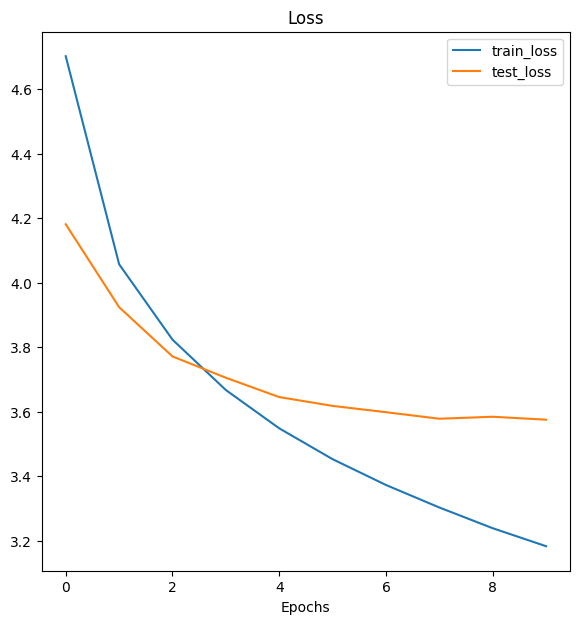

In [ ]:
loss = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)

results = train(model=model,
          train_data_loader = train_gen,
          test_data_loader = val_gen,
          optimizer = optimizer,
          loss_fn = loss,
          epochs = 10,
          device = device)

plot_loss_curves(results)

In [ ]:
torch.save(model, 'gpt_model.pt')

In [100]:
model = torch.load('gpt_model.pt', map_location=torch.device(device), weights_only=False)

In [101]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6])
torch.hstack((a,b))

tensor([1, 2, 3, 4, 5, 6])

In [102]:
a = torch.tensor([[1],[2],[3]])
b = torch.tensor([[4],[5],[6]])
torch.hstack((a,b))

tensor([[1, 4],
        [2, 5],
        [3, 6]])

In [103]:
def generate(model, prompt='', max_len=32):
    tokenized_prompt = tokenizer(prompt, return_tensors='pt')
    input_ids = tokenized_prompt['input_ids'][:, :-1].to(device)
    mask = tokenized_prompt['attention_mask'][:, :-1].to(device)

    while(len(input_ids[0]) < max_len):
        outputs = model(input_ids, mask)
        # outputs 1 x T x D
        prediction_id = torch.argmax(outputs[:, -1, :], axis=-1)

        if prediction_id.squeeze(0).item() == tokenizer.eos_token_id:
            break

        input_ids = torch.hstack((input_ids, prediction_id.view(1, 1)))
        mask = torch.ones_like(input_ids)

    return tokenizer.decode(input_ids[0][1:])

In [104]:
generate(model, "Blade Runner")

"Blade Runner is a great movie. It's a great movie, with great actors and great actors. It's a great movie, and I love"

In [105]:
generate(model, "Dune is ")

'Dune is 200000000000000000000000000'

In [106]:
generate(model, "The worst ")

"The worst 20000000 movie I've seen in a long time. I've seen a lot of bad movies, but this"

In [107]:
generate(model, "Facinating ")

'Facinating 200007, I was 14 and I was 14. I was 14 and I was '

In [108]:
def generate_with_temp(model, prompt='', max_len=32, temperature=0.4):
    tokenized_prompt = tokenizer(prompt, return_tensors='pt')
    input_ids = tokenized_prompt['input_ids'][:, :-1].to(device)
    mask = tokenized_prompt['attention_mask'][:, :-1].to(device)

    while(len(input_ids[0]) < max_len):
        outputs = model(input_ids, mask)
        # outputs.shape 1 x T x Vocab_size
        y = outputs[:, -1, :][0]
        # y.shape: Vocab_size
        distribution = torch.nn.functional.softmax(y / temperature, dim=0)
        prediction_id = np.random.choice(tokenizer.vocab_size, p=distribution.cpu().detach().numpy())

        if prediction_id == tokenizer.eos_token_id:
            break

        input_ids = torch.hstack((input_ids, torch.tensor(prediction_id).to(device).view(1, 1)))
        mask = torch.ones_like(input_ids)

    return tokenizer.decode(input_ids[0][1:])

In [110]:
generate_with_temp(model, "Facinating ")

'Facinating 19771 is a movie about a young boy who is killed by a woman who is interested in a small town. He goes'

In [111]:
generate_with_temp(model, "Dune is ")

'Dune is 200003. The first time I saw it I was 12. I was 14 and I was'

In [112]:
generate_with_temp(model, "The worst ")

"The worst 30s movie I've seen in my life. It's a complete waste of time. There are a few good things that I can"

In [114]:
generate_with_temp(model, "Facinating ")

"Facinating 19770's movie. The plot is simple, the acting is flawless, the story is simple and the acting is perfect"